<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/DSR_1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(mnist_train,mnist_validate, mnist_test), info = tfds.load(
    name='mnist',
    split = ["train[0:80%]","train[80%:]","test"], #train, validate, test
    with_info = True,
    as_supervised = True
)
print (info)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs 

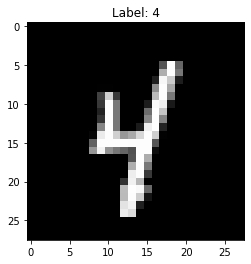

In [4]:
for image, label in mnist_train.take(1):
  plt.imshow(image.numpy().squeeze(), cmap="gray") #change the EagerTensor object to numpy, and remove the pseudo dimension with size 1
  plt.title(f"Label: {label}")
  plt.show()

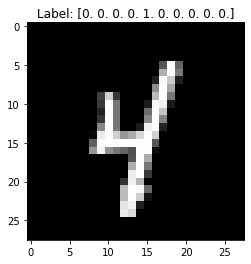

In [15]:
def encode(image, label):
  # tensorflow expects the inputs to be in float32 and it's a good idea to normalize
  # converting the dtype to float 32 does it all
  image_encoded = tf.image.convert_image_dtype(image,dtype=tf.float32)
  #label_encoded = tf.image.convert_image_dtype(label,dtype=tf.float32)
  label_encoded = tf.one_hot(label, depth=10)
  return image_encoded, label_encoded

#mnist_train_pipeline = mnist_train.map(lambda image, label: encode(image,label))
mnist_train_pipeline = mnist_train.map(lambda image, label: encode(image,label))
mnist_validate_pipeline = mnist_validate.map(lambda image, label: encode(image,label))
mnist_test_pipeline = mnist_validate.map(lambda image, label: encode(image,label))

for image, label in mnist_train_pipeline.shuffle(1).take(1):
  plt.imshow(image.numpy().squeeze(), cmap="gray") #change the EagerTensor object to numpy, and remove the pseudo dimension with size 1
  plt.title(f"Label: {label}")
  plt.show()

In [20]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28,28,1)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation="softmax")) #softmax means all output will sum up to one, and each output value will be between 0-1.
model.summary()

model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


(1, 28, 28, 1)
(1, 10)
1/1 [==============================] - 0s 30ms/step
(1, 10)


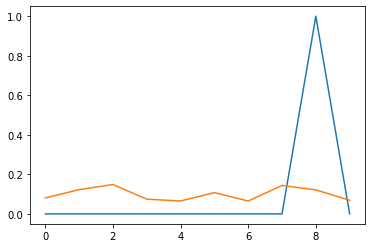

In [23]:
for image,label in mnist_test_pipeline.batch(12).take(1):
#for image,label in mnist_test_pipeline.take(1):
  print (image.shape)
  print(label.shape)

  plt.plot(label[0])

  prediction = model.predict(image)
  print(prediction.shape) 
  plt.plot(prediction[0]) 

In [24]:
loss, accuracy = model.evaluate(mnist_test_pipeline.batch(32), verbose=0)
print(loss)
print(accuracy)

2.387122869491577
0.07999999821186066


In [26]:
history = model.fit(
    mnist_train_pipeline.shuffle(48000).batch(128), # we shuffle to avoid model overfitting the order of batches.
    epochs = 5,
    validation_data = mnist_validate_pipeline.batch(128)
)

Epoch 1/5
375/375 [==============================] - 5s 5ms/step - loss: 0.2966 - accuracy: 0.9163 - val_loss: 0.1611 - val_accuracy: 0.9550
Epoch 2/5
375/375 [==============================] - 3s 5ms/step - loss: 0.1229 - accuracy: 0.9654 - val_loss: 0.1148 - val_accuracy: 0.9672
Epoch 3/5
375/375 [==============================] - 3s 4ms/step - loss: 0.0818 - accuracy: 0.9763 - val_loss: 0.0964 - val_accuracy: 0.9716
Epoch 4/5
375/375 [==============================] - 3s 5ms/step - loss: 0.0580 - accuracy: 0.9831 - val_loss: 0.0855 - val_accuracy: 0.9737
Epoch 5/5
375/375 [==============================] - 3s 4ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.0797 - val_accuracy: 0.9770


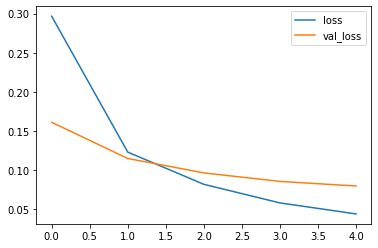

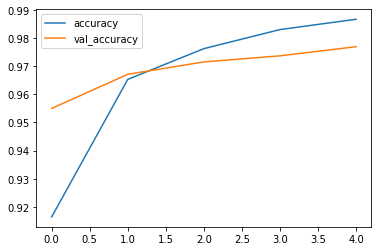

In [38]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()
plt.close()

(12, 28, 28, 1)
(12, 10)
1/1 [==============================] - 0s 81ms/step
(12, 10)


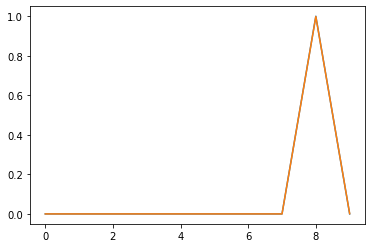

In [39]:
for image,label in mnist_test_pipeline.batch(12).take(1):
#for image,label in mnist_test_pipeline.take(1):
  print (image.shape)
  print(label.shape)

  plt.plot(label[0])

  prediction = model.predict(image)
  print(prediction.shape) 
  plt.plot(prediction[0]) 

In [40]:
!nvidia-smi

Tue Oct 25 13:41:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    27W /  70W |    492MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------